# Welcome to the tutorial on numerical relativity simulations/waveforms and surrogate models!

Today we'll be covering, from a relatively zoomed out perspective:
* what numerical relativity is,
* how to load data from the `Simulating eXtreme Spacetime Collaboration`'s catalog,
* how to build a waveform surrogate
  
So, without further ado, let's get started!

If you're working with `uv` or with `conda` and have the corresponding environment activated, then you should have the packages required for this notebook installed.

### On the first day, God said let there be the SXS Collaboration

We'll start by working with the `sxs` python package:

In [1]:
import sxs # this can take a second to import when doing so for the first time

`sxs` is the only way to interract with the NR simulations produced by the SXS Collaboration (or at least the only way that we *want* you to interact with out simulations).

A simulation, such as that corresponding to our favorite LVK event GW150914---SXS:BBH:0305, can be loaded via the following:

In [2]:
GW150914_simulation = sxs.load("SXS:BBH:0305")

Loading SXS simulations using latest tag 'v3.0.0', published at 2025-05-14T18:17:30Z.


This yields a `Simulations` object, which we'll dig into in more detail later. The main attributes to be aware of for now are

In [3]:
GW150914_simulation.sxs_id, GW150914_simulation.version, GW150914_simulation.Lev

('SXS:BBH:0305v3.0', 'v3.0', 'Lev6')

You'll see a few important bits of information here:
* `SXS ID`: Every simulation in our catalog (`BBH`s, `BNS`s, and `BHNS`s) comes with a unique `SXS ID` characterizing that simulation. These IDs are have no inherent meaning, but loosely correspond to the $N^{\mathrm{th}}$ simulation that we ran, i.e., larger IDs correspond to newer simulations (and thus also potentially newer versions of the NR code that produced them). Note though that more accurate information regarding the age of the simulation can be found elsewhere (we'll come to where this information is stored exactly later on).
* `version`: This, i.e., `v3.0.0`, identifies the version of the data. Unlike the SXS ID, this is an optional specifier (note that we did not specify it when loading, so we were provided with the most recent version). This is key for reproducibility!
* `Lev (resolution)`: This, i.e., `Lev5`, identifies the resolution of the simulation in some complicated way (note again that we did not specify it when loading, so we were provided with the highest resolution, i.e., the highest "Lev"). Unfortunatley, the various "Lev"s do not provide a consistent meaning across the simulations, but higher Levs for a certain simulation *will* correspond to a higher resolution version of that simulation.

To specify these manually, one can simply run, e.g.,

In [4]:
GW150914_simulation = sxs.load("SXS:BBH:0305v3.0/Lev6")

But what does this actually contain? Well, the main output of NR simulations is waveforms! So let's plot the gravitational wave strain $h(t,\theta,\phi)$.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

The following code grabs the strain `WaveformModes` object, which is effectively a fancy container for a 2d array of (time, spherical harmonic modes), then evaluates it at a point on the two sphere, and plots it as a function of time:

Text(0.5, 1.0, 'GW150914-like simulation')

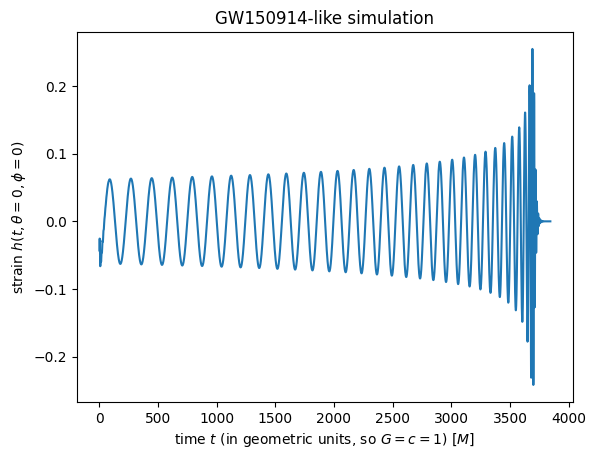

In [6]:
h = GW150914_simulation.h; theta = 0; phi = 0;
plt.plot(h.t, h.evaluate(theta, phi).real)
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(rf'strain $h(t,\theta={np.round(theta, 2)},\phi={np.round(phi, 2)})$')
plt.title('GW150914-like simulation')

Nice! But what is that funny feature at the very beginning of the waveform? Let's zoom in to check it out:

Text(0.5, 1.0, 'GW150914-like simulation')

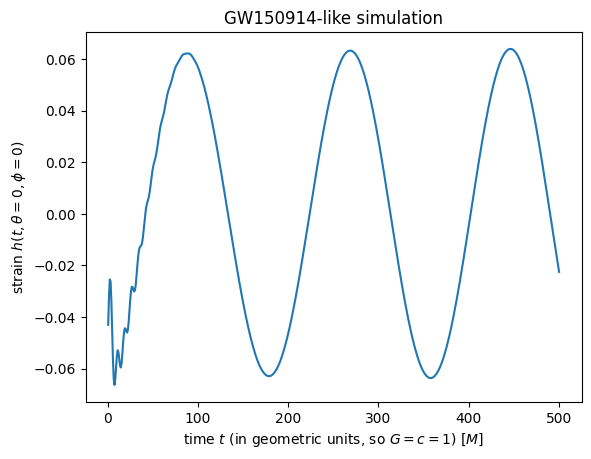

In [7]:
idx_f = np.argmin(abs(h.t - 500)) + 1
plt.plot(h.t[:idx_f], h.evaluate(theta, phi)[:idx_f].real)
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(rf'strain $h(t,\theta={np.round(theta, 2)},\phi={np.round(phi, 2)})$')
plt.title('GW150914-like simulation')

That doesn't look right.... shouldn't the waveform always be smooth? Or at least reasonably smooth? Maybe we should take a step back and learn a bit about numerical relativity...

### What is numerical relativity?

<img src="images/foliation.png" align="right" width="400" height="200">

The whole point of numerical relativity is to solve Einstein's equations:
$$
\begin{align}
G_{\mu\nu}\equiv R_{\mu\nu}-\frac{1}{2}Rg_{\mu\nu}=0,
\end{align}
$$
(because matter isn't real), which tell us what the *spacetime* looks like. More specifically, provided some idea of the spacetime we want to study, e.g., two coalescing black holes, numerical relativity aims to "guess" what that spacetime looks like at *one time*, and then compute what it looks like at *all other times*. But how do we do this?

Well, while not necessarily obvious from the above set of equations, Einstein's equations are nothing more than a series of coupled partial differential equations (PDEs). Consequently, if we are to solve these PDEs, we first want to make sure that they are well-posed, i.e., that the equations have a solution, the solution is unique, and the solution changes continuously with the initial conditions. Fortunately for us, [Yvonne Choquet-Bruhat](https://en.wikipedia.org/wiki/Yvonne_Choquet-Bruhat) already taught us that this can be done, provided one uses the correct *gauge*.

Another way to think of Einstein's equations is simply as the equations of motion stemming from some action; specifically, the Einstein-Hilbert action:
$$
\begin{align}
I=\frac{1}{16\pi}\int R\,\sqrt{-g}d^{4}x.
\end{align}
$$
When written in this form, it's easy to see that this is a *diffeomorphism invariant theory*, i.e., it is independent of the coordinates you choose. Another way to interpret this, however, is that any solution to Einstein's equations is not unique, since you can always perform a coordinate transformation to change your apparent solution. As a result, if we want to have well-posedness of our PDEs so that we can actually put them on a supercomputer and solve them, to do so we have to *fix the gauge*.

A particulary nice choice of gauge is the *generalized harmonic* gauge:
$$
\begin{align}
\square x^{\mu}\equiv\nabla_{\nu}\nabla^{\nu}x^{\mu}=g^{\mu\nu}H_{\nu}(x,g),
\end{align}
$$
where the four functions $H_{\nu}$ can depend on the coodinate functions $x^{\mu}$ and the metric (but not derivatives of the metric). The reason why this gauge choice is nice is because when you write Einstein's equations in this gauge, the principal part (the part of the PDE with the highest-order derivatives) is identical to that of a scalar wave, making it much easier to evolve!
$$
\begin{align}
g^{\mu\nu}\partial_{\mu}\partial_{\nu}g_{\alpha\beta}+2\nabla_{(\alpha}H_{\beta)}+(\mathrm{lower\,order\,derivative\,terms})=0.
\end{align}
$$

With our equations now written in a hyperbolic form and proven to be well-posed, one can now decompose them into space-like *foliations* (i.e., space-like hypersurfaces, see the above figure) and evolve them forward in *time* $t$ by propagating information from one $t=\mathrm{const.}$ hypersurface to the next. What this looks like mathematically is nicely summarized through the ADM formalism, which decomposes the metric as
$$
\begin{align}
ds^{2}=-\alpha^{2}+h_{ij}(dx^{i}+\beta^{i}dt)(dx^{j}+\beta^{j}dt),
\end{align}
$$
where $\alpha$ is the *lapse* measuring the rate of change of proper time with respect to the coordinate time $t$ of the normal observer on each hypersurface, $h_{ij}$ is the instric metric of the $t=\mathrm{const.}$ hypersurfaces, and $\beta^{j}$ is the *shift vector* describing how the spatial coordiantes change for normal observes from one hypersurface to the next.

When written in this form, it turns out that Einstein's equations naturally separate into two forms: *constraint* equations which are satisfied on every $t=\mathrm{const.}$ hypersurface and *evolution* equations which tell you how to evolve from on $t=\mathrm{const.}$ hypersurface to the next. Constraint equations are used to construct initial data for the PDEs, i.e., figuring out what that first hypersurface should look like for some type of gravitational system, while the evolution equations then evole that initial data forward in time $t$.

(This is why we saw the weird features in the waveform above! It is because our initial data doesn't always perfectly satisfy the constraint equations, so one needs to wait some time for that violation of these equations to propagate out of the numerical grid and ensure that the spacetime their simulating matches what they expect.)

By coupling this idea with the generalized harmonic gauge above, and imposing *constraint damping terms* in the PDEs (i.e., terms included to force the NR code to satisfy the constraint equations), one can then straightforwardly* evolve Einstein's equations as PDEs forward in time from one space-like hypersurface to the next, much like how we would do when solving a simple wave equation!

And, if you do this a write the lapse $\alpha$ to disk for each hypersurface, you can make incredible animations of this process such as the following:

In [8]:
from IPython.display import Video

Video("images/simulation.mp4")

### Waveforms from numerical relativity

Above, we gave a brief overview of how one formulates Einstein's equations as well-posed PDEs such that they can be evolved on a supercomputer to obtain the metric $g_{\mu\nu}$ and it's derivatives on some finite region of spacetime.

But what do we really want at the end of the day from these simulations? Is it the metric or something else? Naturally we're all probably thinking we want waveforms, since that's what the data that the LVK Collaboration observes looks like. And, as expected, that intuition is correct! We really do want waveforms. But what's the more fundamental reason for wanting waveforms? The answer is twofold:
* First, imagine the SXS Collaboration simply provided the metric $g_{\mu\nu}$ over the spacetime folation $\Sigma$, i.e., the union of the spacelike hypersurfaces discussed above. That would be A LOT of data! And it would make parameter estimation an absolute nightmare, because the four-dimensional data would be way more expensive to work with than two-dimensional waveforms we're familiar with.
* More importantly, though, that metric data would be incredibly *gauge dependent*! If we decided to change our coordinates arbitrarily as we're allowed to due to the diffeomorphism-invariance of GR via $x'^{\mu}=x^{\mu}+\xi^{\mu}$, we would have a completely new metric $g'^{\mu\nu}=g_{\mu\nu}-2\nabla_{(\mu}\xi_{\nu)}$! How would we ever decide how to pick from the infinite number of coordinates that we could rightfully choose from???

What's amazing about waveforms, or, more specifically, *extracting data at future null infinity* $\mathcal{I}^{+}$---the boundary of asymptotically flat spacetimes---is that it has a specific structure, which highly limits the number of coordinate systems that one can choose from (since one can only ever work with coordinates that respect the specific structure of $\mathcal{I}^{+}$!).

In particular, if one writes down the metric describing asymptotic radiation, i.e., gravitational waves, they obtain the Bondi-Sachs metric:
$$
\begin{align}
ds^{2}&=-Ue^{2\beta}du^{2}-2e^{2\beta}dudr\nonumber\\
&\phantom{=.}+r^{2}\gamma_{AB}(d\theta^{A}-\mathcal{U}^{A}du)(d\theta^{B}-\mathcal{U}^{B}du),
\end{align}
$$
where $A,B\in\{1,2\}$ and $U$, $\beta$, $\mathcal{U}^{A}$, and $\gamma_{AB}$ are functions of $u\equiv t-r$, $r$, and $\theta^{A}$. Each of these functions has an asymptotic expansion, but the one we will be primarily concerned with is that of $\gamma_{AB}$, which is
$$
\begin{align}
\gamma_{AB}=q_{AB}+\frac{1}{r}C_{AB}+\frac{1}{r^{2}}D_{AB}+\cdots
\end{align}
$$
In this expansion, $q_{AB}$ is just the usual round metric on the two-sphere, but $C_{AB}$, the *shear tensor*, represents the leading order correction to the background due to gravitational radiation! This tensor is related to the usual gravitational wave strain observable, $h$, via
$$
\begin{align}
h=\frac{1}{2}\bar{q}^{A}\bar{q}^{B}C_{AB}=\sum\limits_{\ell\geq2, |m|\leq\ell}h_{(\ell,m)}(u)\phantom{}_{-2}Y_{(\ell,m)}(\theta,\phi),
\end{align}
$$
where $q_{A}=-(1,i\sin(\theta))$ is a complex dyad on the two-sphere. This is why the strain is represented by spin-weight $-2$ spherical harmonics, because it is the contraction of a dyad (i.e., a pair of spinors) with a tensor on the celestial two-sphere! Note that, more physically, the presence of two dyads in the contraction is directly related to the fact that the strain has two polarizations, $h_{+}$ and $h_{\times}$.

Immediately, one might be concerned that by only considering $C_{AB}$ and neglecting higher-order corrections like $D_{AB}$ we may be biasing our physical analyses. Fortunately, though, for typical LVK luminosity distances on the order of a few hundred Mpcs, the next leading-order corrections are of magnitude $10^{-20}$ below that of $C_{AB}$! So this approximation really is a completely valid description of the metric perturbations that we observe in detectors.

So how do we extract this from NR simulations? There's two methods for doing this: *extrapolation* and *Cauchy-characteristic evolution*. The first simply fits the metric $g_{\mu\nu}$ with polynomials in $1/r$ in the numerical spacetime and takes the $1/r$ coefficient as $C_{AB}$. This is how almost all publicly-available waveforms are computed. The second instead performs a second evolution of Einstein's equations, but now on light-like slices that connect the finite simulation volume to future null infinity by compacting the radial coordinate so that $\mathcal{I}^{+}$ can actually be included in the numerical grid! Obviously this method is much better, but it is certainly more complicated, so it is taking time to make this data publicly available, but the SXS Collaboration is currently working on this.

Ok, with the theory out of the way, let's look at some waveforms!

### Working with the `sxs` package

As mentioned earlier, the `sxs` package is the main (and really only) way to interact with the `SXS Collaboration`'s catalog of simulations.

However, using this package isn't fool proof! You still need to be aware of some of the physics. In particular, if you didn't know that the initial data of NR simulations wasn't perfect and included the early part of the waveform which contains this "junk radiation" in your gravitaitonal wave analysis, you could obtain nonsensical results. While we've done our best to take care of some of the other nuisances involved with waveforms (e.g., putting the waveforms in some reasonable gauge), the user still has to do a little bit of work, such as removing the early portion of the waveform that contains "junk".

#### Working with individual simulations

Each `Simulations` object has a `Metadata` object as an attribute which stores metadata about the simulation:

In [9]:
GW150914_simulation.metadata

Metadata([('simulation_name',
           'BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6'),
          ('keywords', []),
          ('alternative_names', ['PRIVATE:BBH:0225', 'SXS:BBH:0305']),
          ('metadata_format_revision', 2),
          ('metadata_content_revision', 1),
          ('internal_minor_version', 0),
          ('internal_changelog', {}),
          ('citation_dois', ['10.1088/1361-6382/ab34e2']),
          ('initial_separation', 14.2600708008),
          ('initial_orbital_frequency', 0.016961605632),
          ('initial_adot', -5.30625362797e-05),
          ('initial_ADM_energy', 0.9923541855108845),
          ('initial_ADM_linear_momentum',
           [-5.04414e-11, 1.116714e-10, 5.9e-14]),
          ('initial_ADM_angular_momentum',
           [3.385e-13, -1.0649e-12, 1.0829620209826503]),
          ('initial_dimensionless_spin1',
           [3.2772e-12, -9.165e-13, 0.3300000041229183]),
          ('initial_dimensionless_spin2',
           [-2.778e-13, -1.44e-13, 

There's a lot of information here, such as the black hole masses, spins, eccentricity, mean anomaly, and orbital frequency for the initial data (labeled `initial`) or at some `reference_time` which is some time at which the junk radiation has been deemed to have predominantly left the system. There's also the time of the common horizon formation, the number of orbits, mass and spin information about the remnant black hole, and much more. When cutting the waveform, one wants to use the `relaxation_time` (which is effectively identical to the `reference_time`). Note that this is a very conservative choice, so may cut out more than needed.

Text(0.5, 1.0, 'GW150914-like simulation')

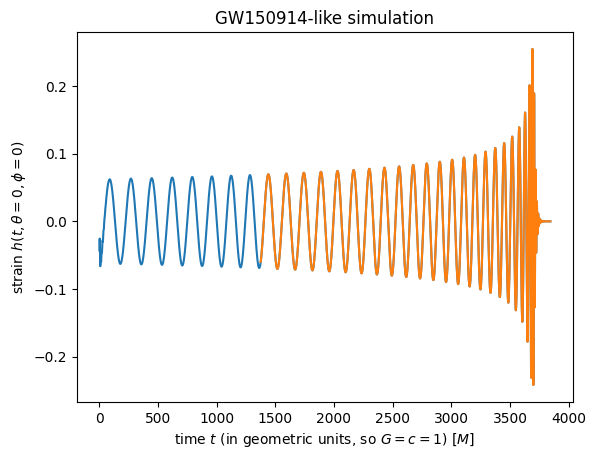

In [10]:
h = GW150914_simulation.h; theta = 0; phi = 0; psi = 0.

idx_relax = np.argmin(abs(h.t - GW150914_simulation.metadata['relaxation_time']))

plt.plot(h.t, h.evaluate(theta, phi, psi).real)
plt.plot(h.t[idx_relax:], h.evaluate(theta, phi, psi)[idx_relax:].real)
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(rf'strain $h(t,\theta={np.round(theta, 2)},\phi={np.round(phi, 2)})$')
plt.title('GW150914-like simulation')

If one wants to look at individal harmonics, like the $(2,2)$ mode, one can do so via:

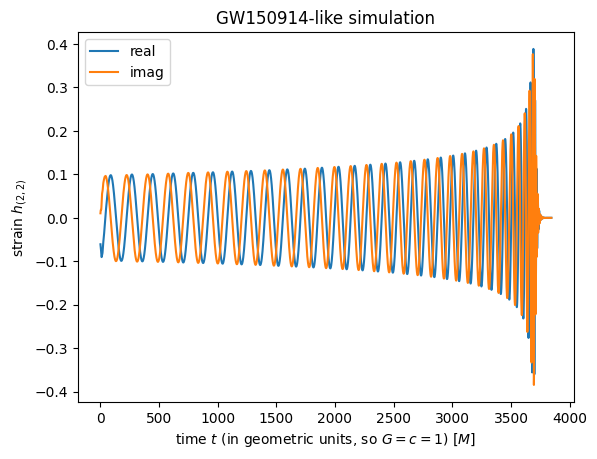

In [11]:
h = GW150914_simulation.h; L = 2; M = 2;

plt.plot(h.t, h.data[:,h.index(L, M)].real, label='real')
plt.plot(h.t, h.data[:,h.index(L, M)].imag, label='imag')
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(r'strain $h_{(' + str(L) + ',' + str(M) + r')}$')
plt.title('GW150914-like simulation')
plt.legend()

Or they could even look at all harmonics via

Text(0.5, 1.0, 'GW150914-like simulation')

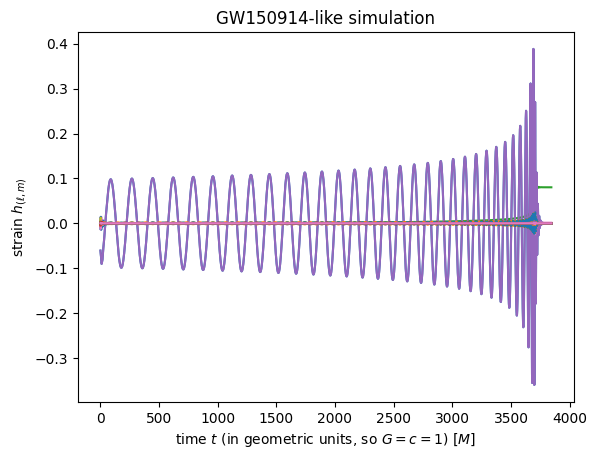

In [12]:
h = GW150914_simulation.h;

plt.plot(h.t, h.data.real)
plt.xlabel('time $t$ (in geometric units, so $G=c=1$) $[M]$')
plt.ylabel(r'strain $h_{(\ell, m)}$')
plt.title('GW150914-like simulation')

(Bonus: what's with the funny offsets at the end???)

And, apart from waveforms, one can also study the horizons via the `Horizons` object to, e.g., study the orbital motion:

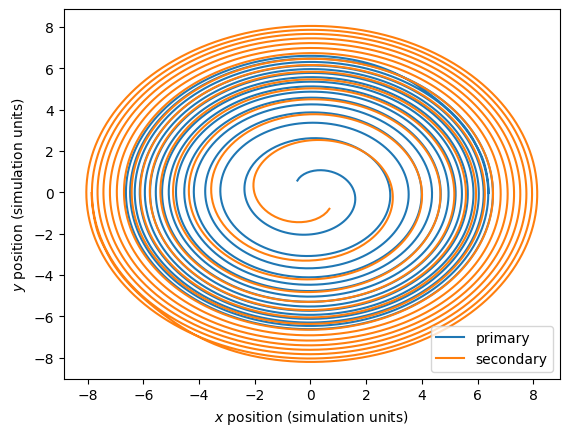

In [13]:
x_A = GW150914_simulation.Horizons.A.coord_center_inertial
x_B = GW150914_simulation.Horizons.B.coord_center_inertial

plt.plot(x_A[:,0], x_A[:,1], label='primary')
plt.plot(x_B[:,0], x_B[:,1], label='secondary')
plt.xlabel(r'$x$ position (simulation units)')
plt.ylabel(r'$y$ position (simulation units)')
plt.legend()

Or the mass (you can also do spin with `.chi_inertial`!) evolution:

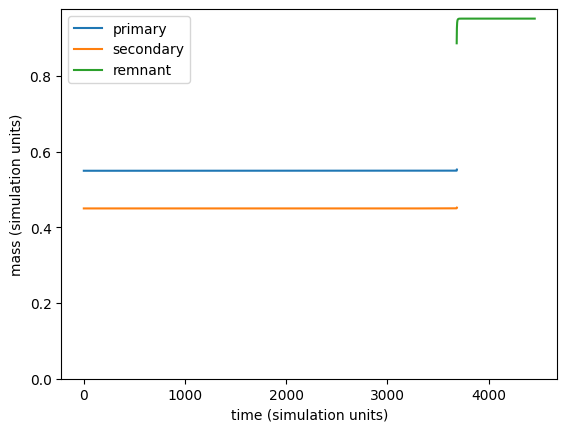

In [14]:
m_A = GW150914_simulation.Horizons.A.christodoulou_mass
m_B = GW150914_simulation.Horizons.B.christodoulou_mass
m_C = GW150914_simulation.Horizons.C.christodoulou_mass

plt.plot(GW150914_simulation.Horizons.A.time, m_A, label=r"primary")
plt.plot(GW150914_simulation.Horizons.B.time, m_B, label=r"secondary")
plt.plot(GW150914_simulation.Horizons.C.time, m_C, label=r"remnant")
plt.ylabel(r"mass (simulation units)")
plt.xlabel(r"time (simulation units)")
plt.ylim(bottom=0.0)
plt.legend();

#### Working with many simulations

Often though, one many not know what specific SXS ID they want to work with! Instead, they're probably more likely just interested in some part of parameter space, e.g., some mass ratio and some spins. For this, we encourage users to use the [SXS Catalog Website](https://data.black-holes.org/simulations/index.html) (which can sometimes take a second to load, because it's running python in your browser!)

<img src="images/marimo.png" width="800" height="200">

We'll select `BBH`, `noneccentric`, `nonprecessing`, and `undeprecated` and then add further filers on `reference_chi1_mag`$\leq0.01$ and `reference_chi2_mag`$\leq0.01$.

This results in the following 73 simulations:

In [15]:
import sxs
df = sxs.load("dataframe", tag="v3.0.0")
sims = [sxs.load(sxs_id) for sxs_id in [
    "SXS:BBH:0185", "SXS:BBH:0186", "SXS:BBH:0188", "SXS:BBH:0189", "SXS:BBH:0192", "SXS:BBH:0195",
    "SXS:BBH:0198", "SXS:BBH:0199", "SXS:BBH:0201", "SXS:BBH:0310", "SXS:BBH:0389", "SXS:BBH:0593",
    "SXS:BBH:1108", "SXS:BBH:1132", "SXS:BBH:1142", "SXS:BBH:1143", "SXS:BBH:1153", "SXS:BBH:1154",
    "SXS:BBH:1155", "SXS:BBH:1166", "SXS:BBH:1167", "SXS:BBH:1178", "SXS:BBH:1179", "SXS:BBH:1220",
    "SXS:BBH:1221", "SXS:BBH:1222", "SXS:BBH:1354", "SXS:BBH:1906", "SXS:BBH:2164", "SXS:BBH:2265",
    "SXS:BBH:2325", "SXS:BBH:2326", "SXS:BBH:2331", "SXS:BBH:2374", "SXS:BBH:2375", "SXS:BBH:2376",
    "SXS:BBH:2377", "SXS:BBH:2378", "SXS:BBH:2425", "SXS:BBH:2477", "SXS:BBH:2480", "SXS:BBH:2483",
    "SXS:BBH:2484", "SXS:BBH:2485", "SXS:BBH:2486", "SXS:BBH:2487", "SXS:BBH:2488", "SXS:BBH:2489",
    "SXS:BBH:2490", "SXS:BBH:2491", "SXS:BBH:2492", "SXS:BBH:2493", "SXS:BBH:2494", "SXS:BBH:2495",
    "SXS:BBH:2496", "SXS:BBH:2497", "SXS:BBH:2498", "SXS:BBH:2499", "SXS:BBH:2516", "SXS:BBH:2707",
    "SXS:BBH:3144", "SXS:BBH:3617", "SXS:BBH:3619", "SXS:BBH:3622", "SXS:BBH:3624", "SXS:BBH:3630",
    "SXS:BBH:3631", "SXS:BBH:3632", "SXS:BBH:3633", "SXS:BBH:3634", "SXS:BBH:3864", "SXS:BBH:3984",
    "SXS:BBH:4434"
]]
qs = [sim.metadata.reference_mass_ratio for sim in sims]
# here I truncate the waveforms to only be 1000M of inspiral + 50M of ringdown for simplicity
hs = [sim.h[np.argmin(abs(sim.h.t - (sim.h.max_norm_time() - 1000))):np.argmin(abs(sim.h.t - (sim.h.max_norm_time() + 50))) + 1] for sim in sims]

We can plot the waveforms via

In [16]:
import matplotlib.cm as cm
import matplotlib.colors as colors

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_55256/643728785.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


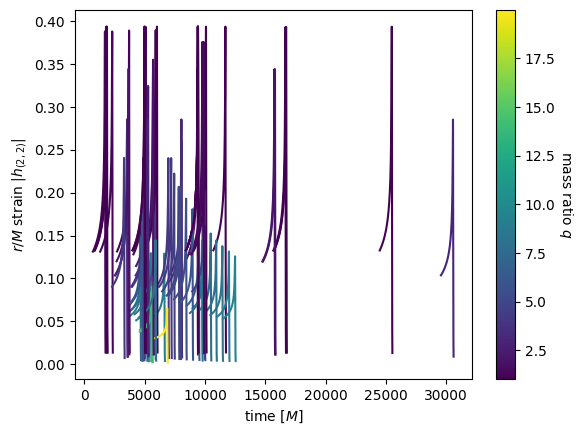

In [17]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

for i, h in enumerate(hs):
    plt.plot(h.t, abs(h.data[:,h.index(2,2)]), color=cmap(norm(qs[i])))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'$r/M$ strain $|h_{(2,2)}|$')
res = plt.scatter([None]*len(hs), [None]*len(hs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14)

Ah shoot! These waveforms are all in coordinates where the peaks are not aligned! Let's change the coordinates so $t=0$ corresponds to the time of max $L^{2}$ norm of the strain over the two-sphere:

In [18]:
for h in hs:
    # interpolate here interpolates the finitely sampled NR data to a spline, and then computes the maximum of that spline
    h.t = h.t - h.max_norm_time(interpolate=True)

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_55256/3070792363.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


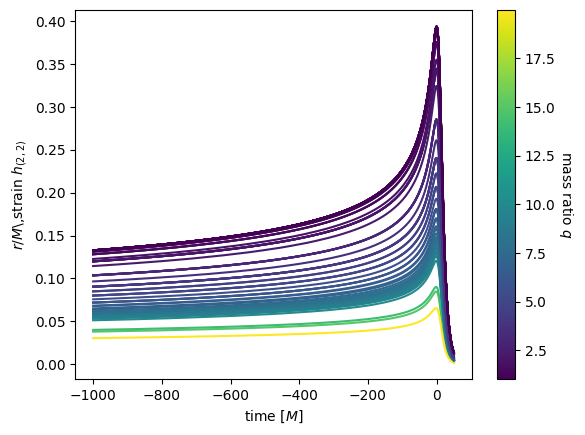

In [19]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

for i, h in enumerate(hs):
    plt.plot(h.t, abs(h.data[:,h.index(2,2)]), color=cmap(norm(qs[i])))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'$r/M$\,strain $h_{(2,2)}$')
res = plt.scatter([None]*len(hs), [None]*len(hs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14)

Much better! How about the phases?

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_55256/2327997953.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')
/Users/keefemitman/Desktop/CCA_tutorial/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/keefemitman/Desktop/CCA_tutorial/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


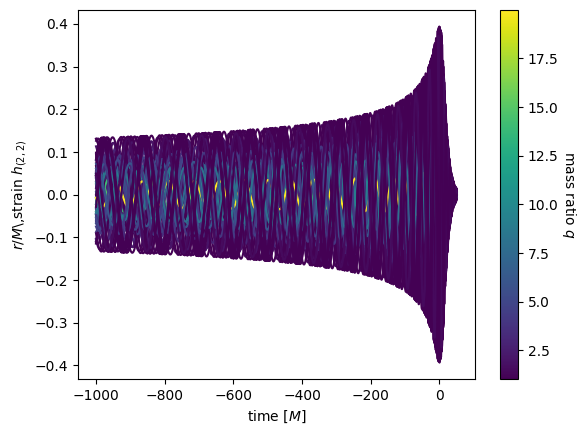

In [20]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

for i, h in enumerate(hs):
    plt.plot(h.t, h.data[:,h.index(2,2)], color=cmap(norm(qs[i])))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'$r/M$\,strain $h_{(2,2)}$')
res = plt.scatter([None]*len(hs), [None]*len(hs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14)

Yuck! But of course! We haven't fixed the angular freedom of our coordinates! Let's do this by making the phase of $(2,2)$ zero and the real part of`(3,3)` positive at $t=-1000M$: 

In [21]:
import quaternionic

In [22]:
for i, h in enumerate(hs):
    d_phase = np.angle(h.data[0,h.index(2,2)])/2
    if (h.data[0,h.index(3,3)] * np.exp(-1j * 3 * d_phase)).real < 0:
        d_phase += np.pi
        
    hs[i] = h.rotate(
        quaternionic.array.from_axis_angle(
            [0., 0., -d_phase]
        )
    )

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_55256/1948609482.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


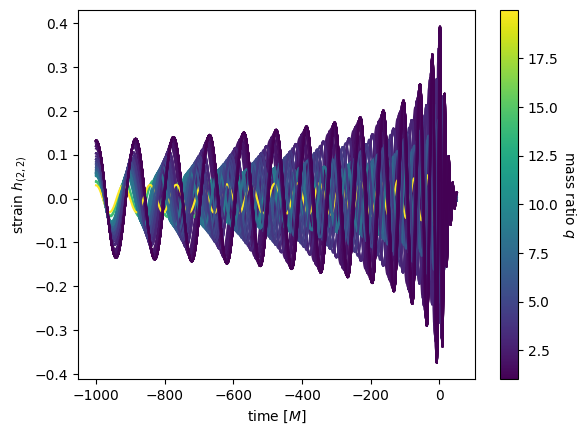

In [23]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

for i, h in enumerate(hs):
    plt.plot(h.t, h.data[:,h.index(2,2)], color=cmap(norm(qs[i])))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'strain $h_{(2,2)}$')

res = plt.scatter([None]*len(hs), [None]*len(hs), c=np.array(qs), vmin=min(qs), vmax=max(qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14)

Much better! There's still certainly some complexity, i.e., the phases evolve at different rates, but this looks much smoother as a function of `q` than before!

Now, although we have waveforms at many mass ratios...

Text(0, 0.5, 'max $L^{2}$ norm')

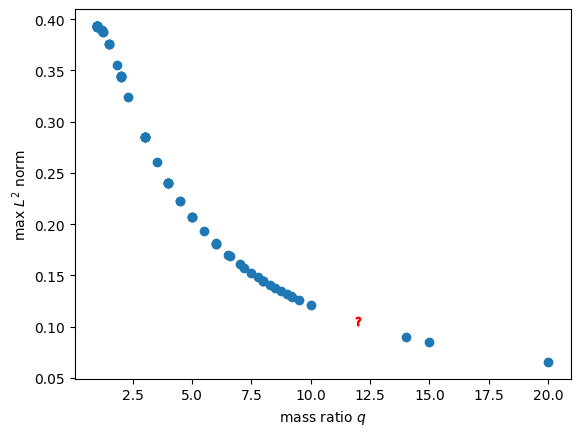

In [24]:
plt.scatter(qs, [max(abs(h.data[:,h.index(2,2)])) for h in hs])
plt.scatter(12, 0.105, marker=r'$?$', color='red')
plt.xlabel('mass ratio $q$')
plt.ylabel('max $L^{2}$ norm')

what if we *reeaaaally* want the waveform at $q=12$? Is there a way to *interpolate* the waveform data across mass ratio parameter space?

### Introduction to surrogate modeling

When building a surrogate model, the most important thing is obtaining a nice set of training data, e.g., the NR simulations we were plotting above. Then, the main steps to building a successful model are:
1. map the training data to be in the same *gauge*, i.e., use a common set of coordinates on $\mathcal{I}^{+}$
  * this not only involves fixing the *gauge* like we did above, but also ensuring a common set of sparse coordinate values (e.g., common time arrays)
2. decompose the complex $h_{(\ell,m)}(u)$ data into data that is easier to model, like amplitude and phase
3. build a basis of time-dependent functions to model the training data with
4. build interpolants for the basis function coefficients across parameter space

Put differently, we're trying to build a model of the strain $h(t,\theta,\phi,\vec{\Lambda})$ (where $\Lambda$ are the intrinsic parameters---like mass ratio---that our waveforms depend on) as:
$$
\begin{align}
h(t,\theta,\phi,\vec{\Lambda})=\sum\limits_{\ell\geq2,|m|\leq\ell}\left(\sum\limits_{i=1}^{N}c_{i}(\vec{\Lambda})u_{i}(t)\right)\phantom{}_{-2}Y_{(\ell,m)}(\theta,\phi),
\end{align}
$$
where $\phantom{}_{-2}Y_{(\ell,m)}(\theta,\phi)$ are the usual spin-weight $-2$ spherical harmonics, $u_{i}(t)$ are our temporal basis functions, and $c_{i}(\vec{\Lambda})$ are the coefficients weighting $u_{i}(t)$ as a function of our intrinsic parameters $\vec{\Lambda}$.

#### step 1: preparing training data

We've already done the first part of step 1, i.e., fixing the gauge by aligning in time and phase, so now let's map our waveforms to a common time array

In [25]:
t_common = np.arange(-1000, 50, 0.1)
for i, h in enumerate(hs):
    hs[i] = h.interpolate(t_common)

#### step 2: data decomposition

Clearly an oscillatory function like $h_{(\ell,m)}$ will be hard to model, so let's decompose it into amplitude and phase which should be smoother across $q$

In [26]:
As = np.array([abs(h.data[:,h.index(2,2)]) for h in hs])
phis = np.array([np.unwrap(np.angle(h.data[:,h.index(2,2)])) for h in hs])

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_55256/163599307.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


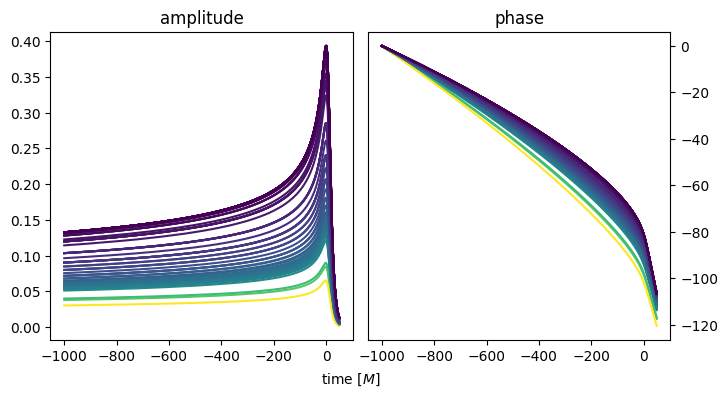

In [27]:
norm = colors.Normalize(vmin=min(qs), vmax=max(qs))
cmap = cm.get_cmap('viridis')

fig, axis = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
plt.subplots_adjust(wspace=0.05)

for i in range(len(As)):
    axis[0].plot(t_common, As[i], color=cmap(norm(qs[i])))
    axis[1].plot(t_common, phis[i], color=cmap(norm(qs[i])))
axis[1].yaxis.tick_right()
axis[0].set_title('amplitude')
axis[1].set_title('phase')
fig.text(0.5, 0.0, r'time $[M]$', ha='center');

#### step 3a: building a basis with Singular Value Decomposition

At this point, we now have two $(10500, 73)$ matrices (time by mass ratio): one for amplitudes and one for phases, and we want to find a basis which represents these two data sets well.

Naturally, the most obvious thing to try first is using Singular Value Decomposition (SVD) to find the most important "modes" of the data, i.e., the basis which does the best at modeling the various columns of our data matrices when combined in some linear fashion. Constructing the SVD of some matrix simply ammounts to rewriting that matrix, call it $L$, as the product of three matrices
$$
L=U\cdot\Sigma\cdot V^{\dagger},
$$
where $U$ is an $m\times m$ complex unitary matrix, $\Sigma$ is an $m\times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal, $V$ is an $n\times n$ complex unitary matrix, with $V^{\dagger}$ is conjugate transpose. When written in this form, the columns of $U$ tell us the most important basis vectors, while the $i^{\mathrm{th}}$ diagonal element of $\Sigma$ tell us how important the $i^{\mathrm{th}}$ column of $U$ is to our basis. So what's our basis?

Let's begin by computing the SVDs of each data set

In [28]:
u_As, s_As, vh_As = np.linalg.svd(As.T)
u_phis, s_phis, vh_phis = np.linalg.svd(phis.T)

Clearly there are some features in our data which are shared broadly across our data set, while there are some other features that are much less important

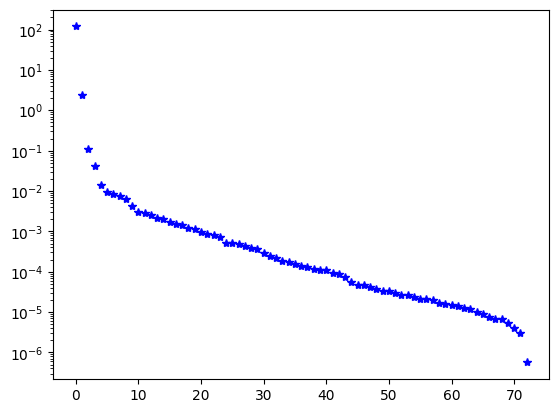

In [29]:
plt.semilogy(range(len(As)), s_As, 'b*')

And the first few basis functions look like what we'd expect!

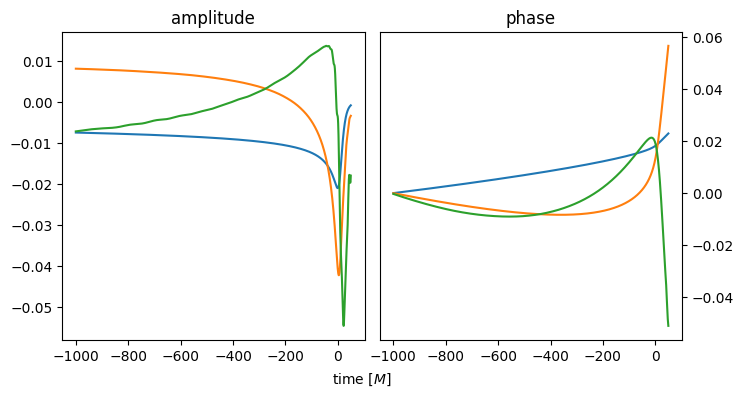

In [30]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
plt.subplots_adjust(wspace=0.05)

for i in range(3):
    axis[0].plot(t_common, u_As[:,i])
    axis[1].plot(t_common, u_phis[:,i])
axis[1].yaxis.tick_right()
axis[0].set_title('amplitude')
axis[1].set_title('phase')
fig.text(0.5, 0.0, r'time $[M]$', ha='center');

But how well does this basis actually model our training data? To check this, we can compute the projection coefficients of a finite number of basis functions against one element of our training data set and compute what the residual between the approximation and the training data is:

Text(0, 0.5, 'residual')

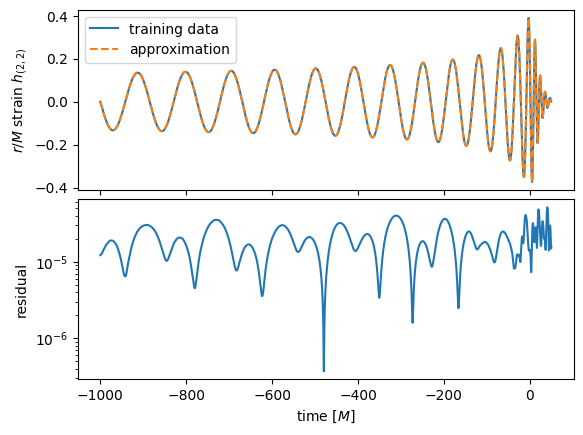

In [31]:
# Choose some number of basis functions and pick out the corresponding basis functions
A_basis_size = 7
phi_basis_size = 7

A_basis_set = u_As[:, 0:A_basis_size]
phi_basis_set = u_phis[:, 0:phi_basis_size]

# Choose one of our training waveforms
idx_test = 10

# Compute its representation in the linear space defined by the space of our basis
proj_coeffs_A = np.dot(A_basis_set.conjugate().transpose(), As[idx_test])
A_approx = np.dot(A_basis_set, proj_coeffs_A.transpose()).transpose()

proj_coeffs_phi = np.dot(phi_basis_set.conjugate().transpose(), phis[idx_test])
phi_approx = np.dot(phi_basis_set, proj_coeffs_phi.transpose()).transpose()

fig, axis = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.05)

axis[0].plot(t_common, hs[idx_test].data[:,hs[idx_test].index(2,2)].imag, label='training data')
axis[0].plot(t_common, A_approx * np.exp(1j * phi_approx).imag, ls='--', label='approximation')
axis[1].semilogy(t_common, abs(hs[idx_test].data[:,hs[idx_test].index(2,2)] - A_approx * np.exp(1j * phi_approx)))
axis[0].legend()
axis[0].set_ylabel(r'$r/M$ strain $h_{(2,2)}$')
axis[1].set_xlabel(r'time $[M]$')
axis[1].set_ylabel('residual')

Not bad! But can we do better?

#### step 3b: computing basis coefficients with Empirical Interpolant Method

While SVD finds a basis that best captures the features of the data set, it is not necessarily the most *computationally efficient*. Consequently, an alternative to SVD that is often used in the surrogate modeling community is the Empirical Interpolant Method (EIM). Akin to how SVD provides a model for $h_{(\ell,m)}(t)$ as
$$
h_{(\ell,m)}(t)^{\mathrm{SVD}}=\sum\limits_{i=1}^{N}c_{i}(\vec{\Lambda})u_{i}(t),
$$
EIM also models the strain as a sum of weights against basis functions, but instead of using the projection coefficients, EIM instead uses waveform evaluations at specific points in time that are deemed more important than others, so one has
$$
h_{(\ell,m)}(t)^{\mathrm{EIM}}=\sum\limits_{i=1}^{N}h(t_{i};\vec{\Lambda})B_{i}(t),
$$
where the $B_{i}(t)$ basis functions are just linear combinations of the $u_{i}(t)$ basis functions resulting from SVD.

To use EIM, we can rely on Chad Galley's `rompy` (reduced order modeling) package (see [arXiv:1308.3565](https://arxiv.org/pdf/1308.3565) for more!):

In [32]:
import rompy

In [33]:
A_eim = rompy.EmpiricalInterpolant(A_basis_set.transpose())
phi_eim = rompy.EmpiricalInterpolant(phi_basis_set.transpose())

So where did EIM place the time nodes $t_{i}$?

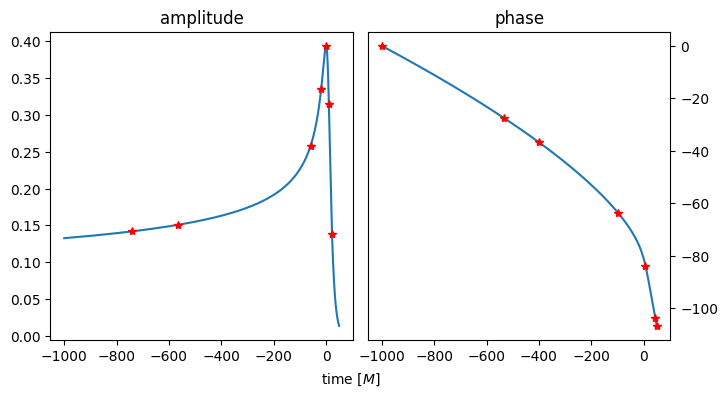

In [34]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
plt.subplots_adjust(wspace=0.05)

axis[0].plot(t_common, As[idx_test])
axis[0].plot(t_common[A_eim.indices], As[idx_test][A_eim.indices], 'r*')

axis[1].plot(t_common, phis[idx_test])
axis[1].plot(t_common[phi_eim.indices], phis[idx_test][phi_eim.indices], 'r*')

axis[1].yaxis.tick_right()
axis[0].set_title('amplitude')
axis[1].set_title('phase')
fig.text(0.5, 0.0, r'time $[M]$', ha='center');

Interesting! Many points are clustered near the merger, which is maybe what we'd expect since this is the most complicated part of the waveform!

So how does the modeling actually compare to SVD then?

In [35]:
A_approx_EIM = np.dot(A_eim.B.transpose(), As[idx_test][A_eim.indices])
phi_approx_EIM = np.dot(phi_eim.B.transpose(), phis[idx_test][phi_eim.indices])

Text(0, 0.5, 'residual')

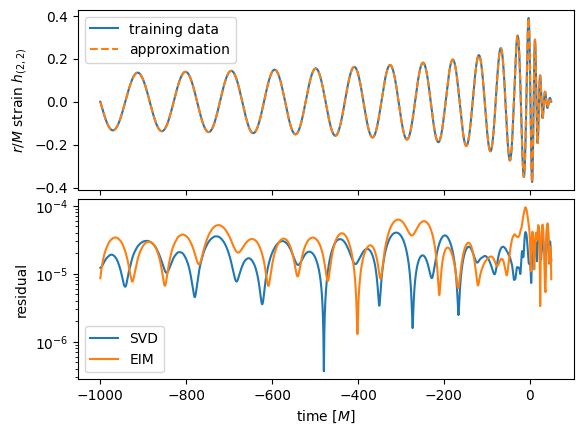

In [36]:
fig, axis = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.05)

axis[0].plot(t_common, hs[idx_test].data[:,hs[idx_test].index(2,2)].imag, label='training data')
axis[0].plot(t_common, A_approx_EIM * np.exp(1j * phi_approx_EIM).imag, ls='--', label='approximation')
axis[1].semilogy(t_common, abs(hs[idx_test].data[:,hs[idx_test].index(2,2)] - A_approx * np.exp(1j * phi_approx)), label='SVD')
axis[1].semilogy(t_common, abs(hs[idx_test].data[:,hs[idx_test].index(2,2)] - A_approx_EIM * np.exp(1j * phi_approx_EIM)), label='EIM')
axis[0].legend()
axis[1].legend()
axis[0].set_ylabel(r'$r/M$ strain $h_{(2,2)}$')
axis[1].set_xlabel(r'time $[M]$')
axis[1].set_ylabel('residual')

Great! The residual is identical. But note that *we've only used the waveform evaluated at seven time points* to obtain the EIM result, unlike the 10,500 used for SVD! This is the beauty of reduced order modeling. While it may not be important for this trivial example, when dealing with a lot of waveform data for a large parameter space this can make a big difference.

#### step 4a: interpolating coefficients across parameter space with splines

At this point, we now have two data matrices for the amplitudes and phases from our EIM, visualized below:

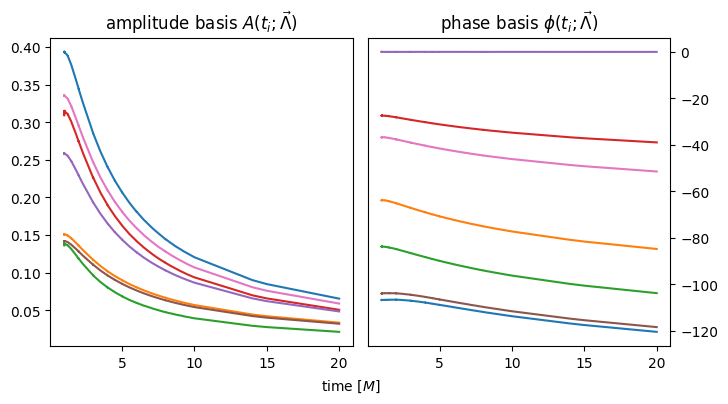

In [37]:
fig, axis = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
plt.subplots_adjust(wspace=0.05)
axis[0].plot(sorted(qs), [x for _, x in sorted(zip(qs, As[:,A_eim.indices]))])
axis[1].plot(sorted(qs), [x for _, x in sorted(zip(qs, phis[:,phi_eim.indices]))])
axis[1].yaxis.tick_right()
axis[0].set_title(r'amplitude basis $A(t_{i};\vec{\Lambda})$')
axis[1].set_title(r'phase basis $\phi(t_{i};\vec{\Lambda})$')
fig.text(0.5, 0.0, r'time $[M]$', ha='center');

Each of these coefficients look fairly smooth across parameter space, so let's simply try modeling them with splines.

In [38]:
from scipy.interpolate import splrep, splev

In [39]:
A_eim_spline = [splrep(sorted(qs), [x for _, x in sorted(zip(qs, As[:,A_eim.indices][:,i]))], k=2) for i in range(len(A_eim.indices))]
phi_eim_spline = [splrep(sorted(qs), [x for _, x in sorted(zip(qs, phis[:,phi_eim.indices][:,i]))], k=2) for i in range(len(phi_eim.indices))]

Easy enough! Now we can evaluate them:

In [40]:
q = 12
A_eim_spline_eval = np.array([splev(q, A_eim_spline[i]) for i in range(len(A_eim.indices))])
phi_eim_spline_eval = np.array([splev(q, phi_eim_spline[i]) for i in range(len(phi_eim.indices))])
h_approx = np.dot(A_eim.B.transpose(), A_eim_spline_eval) * np.exp(1j * np.dot(phi_eim.B.transpose(), phi_eim_spline_eval))

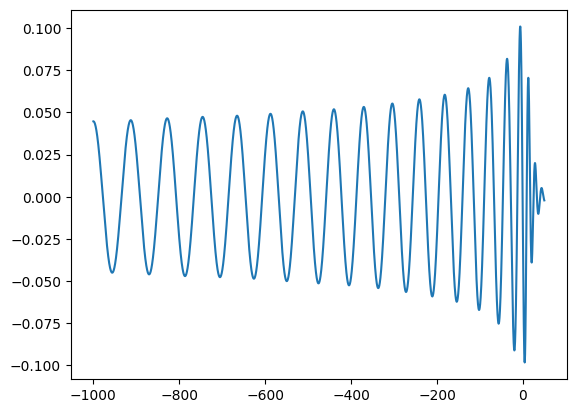

In [41]:
plt.plot(t_common, h_approx)

Looks pretty reasonable! But does it fit in with our plot from before?

Text(0, 0.5, 'max $L^{2}$ norm')

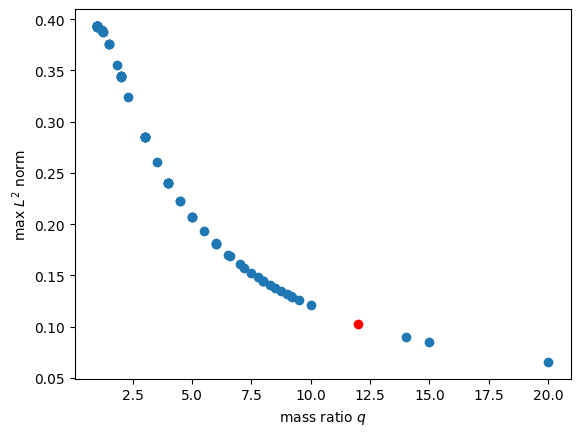

In [42]:
plt.scatter(qs, [max(abs(h.data[:,h.index(2,2)])) for h in hs])
plt.scatter(q, max(abs(h_approx)), color='red')
plt.xlabel('mass ratio $q$')
plt.ylabel('max $L^{2}$ norm')

Nice! And to really show things off, we can even recreate the full waveform plot from earlier

/var/folders/63/h_06fwvj5_v_gyn7d32k4dbm0000gn/T/ipykernel_55256/1668157098.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


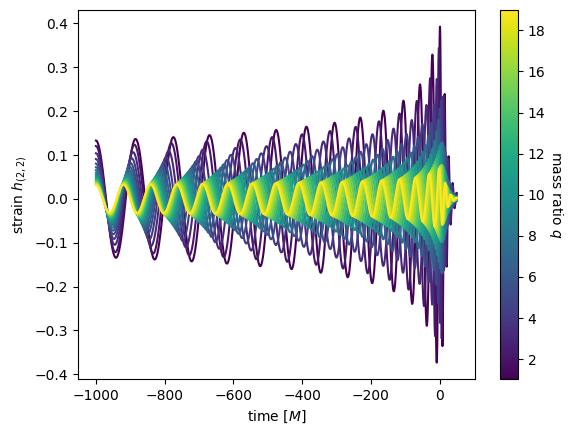

In [43]:
fine_qs = np.arange(1, 20, 1)

norm = colors.Normalize(vmin=min(fine_qs), vmax=max(fine_qs))
cmap = cm.get_cmap('viridis')

for q in fine_qs:
    A_eim_spline_eval = np.array([splev(q, A_eim_spline[i]) for i in range(len(A_eim.indices))])
    phi_eim_spline_eval = np.array([splev(q, phi_eim_spline[i]) for i in range(len(phi_eim.indices))])
    h_approx = np.dot(A_eim.B.transpose(), A_eim_spline_eval) * np.exp(1j * np.dot(phi_eim.B.transpose(), phi_eim_spline_eval))
    plt.plot(t_common, h_approx, color=cmap(norm(q)))
plt.xlabel(r'time $[M]$')
plt.ylabel(r'strain $h_{(2,2)}$')

res = plt.scatter([None]*len(fine_qs), [None]*len(fine_qs), c=np.array(fine_qs), vmin=min(fine_qs), vmax=max(fine_qs), cmap='viridis')
c = plt.colorbar(res)
c.set_label('mass ratio $q$', rotation=270, labelpad=14)

### Future challenges:
* Can you think of something better to use than splines for modeling the $A(t_{i};\vec{\Lambda})$ and $\phi(t_{i};\vec{\Lambda})$ functions? Maybe GPR?
* Can you model the other modes of the waveform?
* Can you include spins? (avoid precession, as this requires a bit more work)
* Can you make your model autodifferentiable with `jax`?